# Supervised machine learning final assignment

- Name: Hendrik Reitsma
- Studentnumber: 444264
- Date: 25-5-2022

Assignment: Load, inspect and clean the data. Split the data into a training set and a validation set and a test set. Use a simple classifier as a baseline. Train various classifiers. Motivate your choice in relation to the characteristics of the dataset. Try to combine them into an ensemble learning model that outperforms all of the others. Please see the attached excel-file for the specific grading matrix.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,\
                             GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from prediction.tuning import ClassifierTuning
from prediction.evaluate_model import evaluate_model

Something about the dataset, and the description of the data (from the names files)

## 1. Read and inspect the data

In [2]:
df = pd.read_csv('data/parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [3]:
df.set_index('name', inplace=True)

Let's see if there are any empty values in the dataframe.

In [4]:
df.isnull().sum().sum()

0

If we use describe we can further investigate the data

In [5]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


It seems that the data is not the same scale. Scaling will be necessary.

In [6]:
df.status.value_counts()

1    147
0     48
Name: status, dtype: int64

The data is unbalanced towards the 1 status (have parkinsons). We will have to take this into account when calculating the accuracy of the model.

## 2. Data exploration and preparation

### 2.1 Multicollinearity

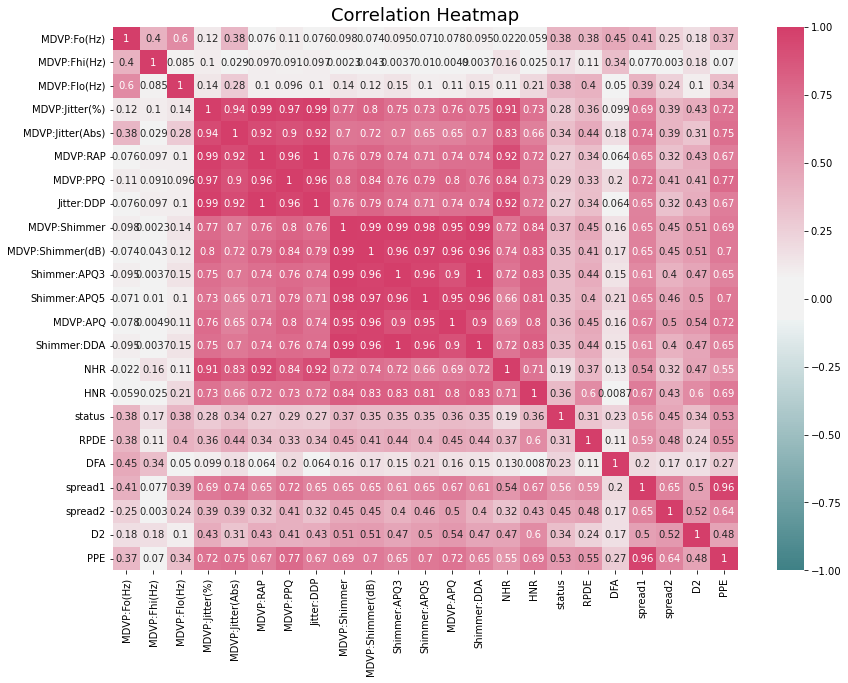

In [7]:
def correlation_heatmap(df):
    """
    Function that shows a correlation heatmap with r values annotated.
    """
    plt.rcParams["figure.figsize"] = (14, 10)
    cmap = sns.diverging_palette(h_neg = 200, h_pos = 360, s = 74, l= 50, sep=20, n=11, center='light',as_cmap=True)
    title = 'Correlation Heatmap'
    plt.title(title, fontsize=18)
    sns.heatmap(df.corr().abs(), annot = True, cmap=cmap, vmin=-1, vmax=1)
    plt.show()

correlation_heatmap(df)

To prevent overfitting, we must deal with multicollinearity.

-   The columns 'MDVP:Jitter(%)' 'MDVP:Jitter(Abs)' 'MDVP:RAP' 'MDVP:PPQ' 'Jitter:DDP' 'NHR' are all highly correlated.
-   The columns 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA' are also highly correlated.
-   The columns 'PPE', 'spread1' are also highly correlated.

Keep only 'MDVP:Jitter(%)' and 'MDVP:Shimmer(dB)'
'spread1'


In [8]:
df = df[['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Shimmer', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2']]

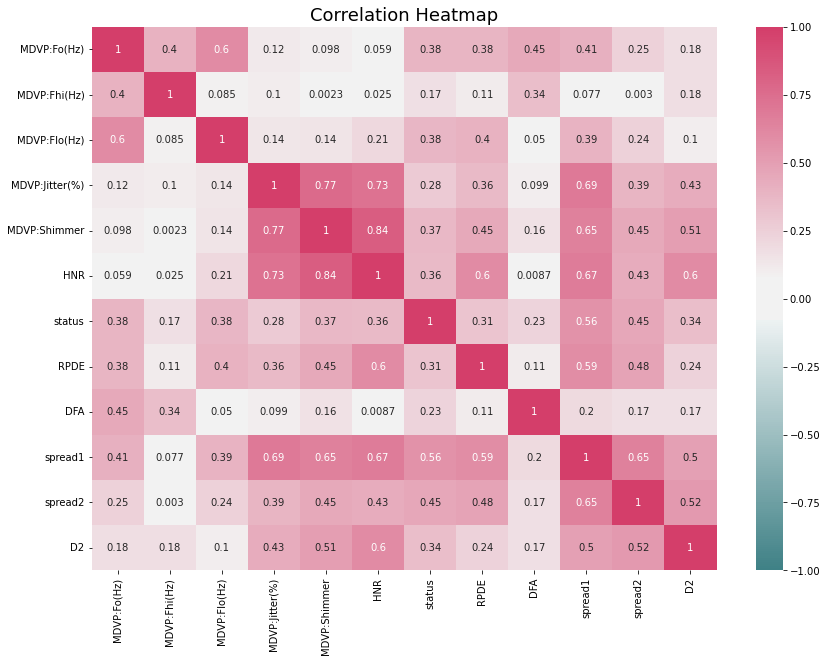

In [9]:
correlation_heatmap(df)

### 2.2 Skewness

Skew is the degree of distortion from a normal distribution. This way the models will be trained unevenly. We can normalize the data to get a more normal distribution.

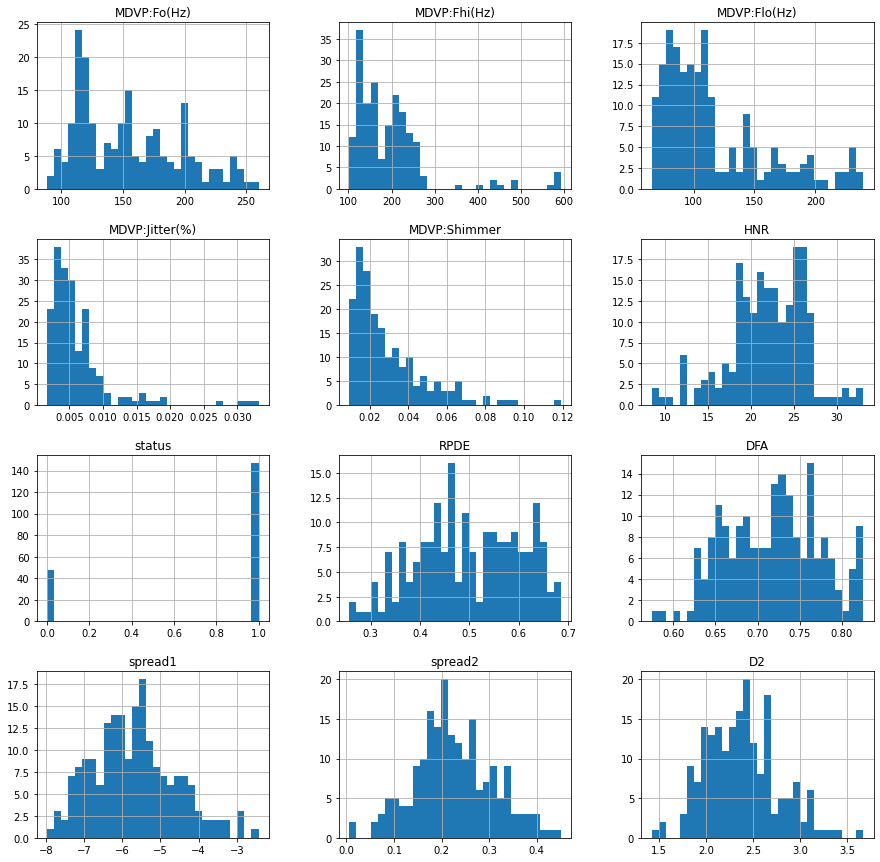

In [10]:
df.hist(bins=30, figsize=(15, 15));

The columns ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Shimmer'] have a skewed distribution.

In [11]:
skewed_columns = df.skew().sort_values(ascending=False)
skewed_columns = skewed_columns.loc[skewed_columns > 0.5]
skewed_columns

MDVP:Jitter(%)    3.084946
MDVP:Fhi(Hz)      2.542146
MDVP:Shimmer      1.666480
MDVP:Flo(Hz)      1.217350
MDVP:Fo(Hz)       0.591737
dtype: float64

In [12]:
skewed_columns.index.tolist()

['MDVP:Jitter(%)',
 'MDVP:Fhi(Hz)',
 'MDVP:Shimmer',
 'MDVP:Flo(Hz)',
 'MDVP:Fo(Hz)']

Let's try to get rid of the skewness with a log transform

In [13]:
df_log = df.copy()
for col in skewed_columns.index.tolist():
    df_log[col] = np.log1p(df_log[col])

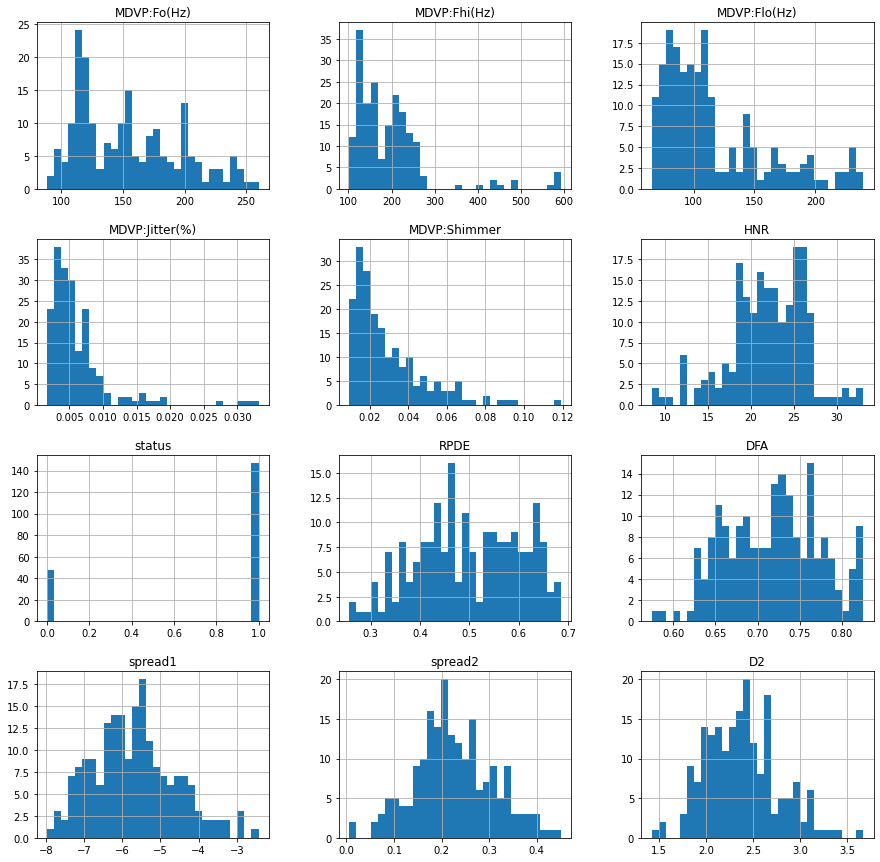

In [14]:
df.hist(bins=30, figsize=(15, 15));

In [15]:
skewed_columns_log = df_log.skew().sort_values(ascending=False)
skewed_columns_log = skewed_columns_log.loc[skewed_columns_log > 0.75]
skewed_columns_log

MDVP:Jitter(%)    3.053912
MDVP:Shimmer      1.603423
MDVP:Fhi(Hz)      1.097633
dtype: float64

MDVP:Jitter(%), MDVP:Shimmer and MDVP:Fhi(Hz) still are skewed distributions. Let's try the boxcox transform instead.

In [16]:
for col in skewed_columns.index.tolist():
    df[col] = stats.boxcox(df[col])[0]

In [17]:
skewed_columns = df.skew().sort_values(ascending=False)
skewed_columns

spread1           0.432139
D2                0.430384
spread2           0.144430
MDVP:Flo(Hz)      0.104907
MDVP:Fhi(Hz)      0.069295
MDVP:Shimmer      0.058917
MDVP:Fo(Hz)       0.042435
MDVP:Jitter(%)    0.006593
DFA              -0.033214
RPDE             -0.143402
HNR              -0.514317
status           -1.187727
dtype: float64

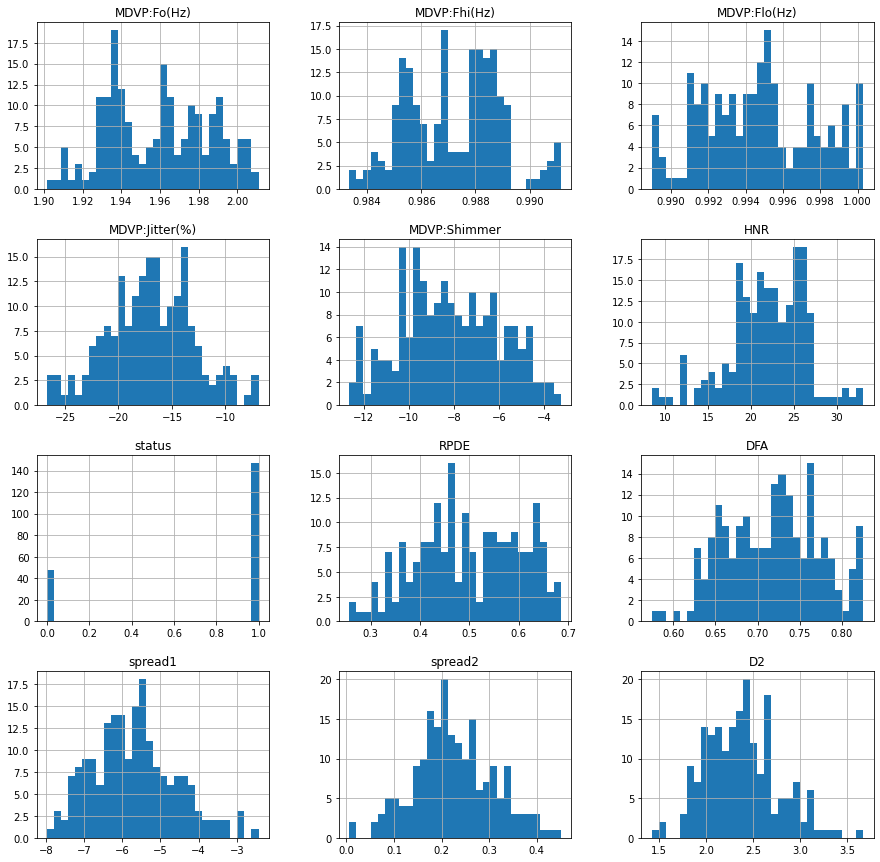

In [18]:
df.hist(bins=30, figsize=(15, 15));

The distributions look more like normal distibutions now which is better for some machine learning techniques.

### 2.3 Prepare data

Define the target column, which is the status of patient regarding having parkinsons or not.
The measurements are the predictors.
For ease of use, the target column will be moved to the end.

In [19]:
df = df[[c for c in df if c not in ['status']] + ['status']]

In [20]:
y= df['status']
X = df.iloc[:,1:-1]

In [21]:
X.shape

(195, 10)

As discussed before, the data should be scaled.

In [22]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

## 3. Machine learning techniques
We want to distinguish between parkinson patients and non parkinson patients. This leads us to classification techniques. Different models will be trained, and the best one will be chosen as the final model.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

### 3.1 Decision tree classifier

In [24]:
dtc = DecisionTreeClassifier()
dtc_clf = dtc.fit(X_train, y_train)

In [25]:
evaluate_model(dtc_clf, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.89      0.95      0.92        44

    accuracy                           0.88        59
   macro avg       0.86      0.81      0.83        59
weighted avg       0.88      0.88      0.88        59

[[10  5]
 [ 2 42]]


{'time': 0.0014964580535888673,
 'error': 0.13389830508474576,
 'mean_accuracy': 0.8661016949152541}

### 3.1.2 Support vector classifier

In [26]:
# Create base model:
svc = SVC(C=10)
svc_clf = svc.fit(X_train, y_train) 

In [27]:
evaluate_model(svc_clf, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.95      0.95      0.95        44

    accuracy                           0.93        59
   macro avg       0.91      0.91      0.91        59
weighted avg       0.93      0.93      0.93        59

[[13  2]
 [ 2 42]]


{'time': 0.002193188667297363,
 'error': 0.06779661016949153,
 'mean_accuracy': 0.9322033898305084}

### 3.1.3 Logistic regression classifier

In [28]:
# Create base model:
lr = LogisticRegression(C=10)
lr_clf = lr.fit(X_train, y_train) 

In [29]:
evaluate_model(lr_clf, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.84      0.86      0.85        44

    accuracy                           0.78        59
   macro avg       0.71      0.70      0.70        59
weighted avg       0.78      0.78      0.78        59

[[ 8  7]
 [ 6 38]]


{'time': 0.007878851890563966,
 'error': 0.22033898305084745,
 'mean_accuracy': 0.7796610169491525}

All models are a bit worse at predicting the negative status. This is because there are around ~150 1's and 50 0's. The model is being trained more by 1's so it is better at predicting those. Because the data is unbalanced, it will be better to look at F1 score vs accuracy. Also, for trying to find patients with a disease, there is a bigger downside to predicting false negatives.

To improve a model, hyperparameter tuning can be done. To reduce runtime of the script, we only tune the logistic regression model.
Random search allows narrowing down the range for hyperparameters. Using GridSearchCV, all combinations can be tried for further accuracy improvement. 

In [30]:
# define parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l1', 'l2', 'elasticnet']
c_values = [100, 30, 20, 15, 13, 11, 10, 9, 1.0, 0.1, 0.01]
# define grid search
param_grid = dict(solver=solvers,penalty=penalty,C=c_values)

In [31]:
tuning = ClassifierTuning(X_train, y_train)
lr_tuned = tuning.tuning_grid(classifier=lr, param_grid = param_grid, scoring = 'f1')
lr_clf_tuned = lr_tuned.best_estimator_

Fitting 3 folds for each of 165 candidates, totalling 495 fits


c:\Users\hendr\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.92238686        nan 0.91785072 0.92238686
 0.92238686 0.92238686 0.92238686 0.92238686        nan        nan
        nan        nan        nan        nan        nan 0.92238686
        nan 0.91785072 0.92238686 0.92238686 0.92238686 0.92238686
 0.91785072        nan        nan        nan        nan        nan
        nan        nan 0.92238686        nan 0.91370993 0.92238686
 0.92238686 0.92238686 0.92238686 0.91370993        nan        nan
        nan        nan        nan        nan        nan 0.92238686
        nan 0.91370993 0.92776988 0.92776988 0.92238686 0.92238686
 0.91370993        nan        nan        nan        nan        nan
        nan        nan 0.92238686        nan 0.91370993 0.92776988
 0.92776988 0.92238686 0.92776988 0.91370993        nan        nan
        nan        nan        nan        nan        n

In [32]:
evaluate_model(lr_clf_tuned, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.84      0.86      0.85        44

    accuracy                           0.78        59
   macro avg       0.71      0.70      0.70        59
weighted avg       0.78      0.78      0.78        59

[[ 8  7]
 [ 6 38]]


{'time': 0.012923765182495116,
 'error': 0.22033898305084745,
 'mean_accuracy': 0.7796610169491525}

The hyperparameter tuning did not improve the accuracy or f1 score of the model.

## 3.2 Ensemble methods

### 3.1 Randomforest

The random forest is classifier uses bagging of the decision tree model to create a more powerful model.

In [33]:
# Create base model:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_clf = rf.fit(X_train, y_train)

In [34]:
evaluate_model(rf_clf, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.89      0.95      0.92        44

    accuracy                           0.88        59
   macro avg       0.86      0.81      0.83        59
weighted avg       0.88      0.88      0.88        59

[[10  5]
 [ 2 42]]


{'time': 0.15098578929901124,
 'error': 0.11864406779661017,
 'mean_accuracy': 0.8813559322033898}

The random forest improved the decision tree accuracy/f1 score.

### 3.2 Gradient boosting classifier

Gradient boosting uses boosting to improve on the decision tree.

In [35]:
# Create base model:
gb = GradientBoostingClassifier(n_estimators = 200, random_state = 42)
gb_clf = gb.fit(X_train, y_train)

In [36]:
evaluate_model(gb_clf, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.91      0.93      0.92        44

    accuracy                           0.88        59
   macro avg       0.85      0.83      0.84        59
weighted avg       0.88      0.88      0.88        59

[[11  4]
 [ 3 41]]


{'time': 0.18509459495544434,
 'error': 0.11864406779661017,
 'mean_accuracy': 0.8813559322033898}

The gradient boosting improved the decision tree accuracy/f1 score.

### 3.3 StackingClassifier

The stacking classifier uses the output of the estimators as input for the final estimator. 

In [37]:
estimators = [('dtc', dtc_clf),
              ('svc', svc_clf),
              ('lr', lr_clf)]

stacked_clf = StackingClassifier(estimators=estimators, cv=None, final_estimator=LogisticRegression())

In [38]:
evaluate_model(stacked_clf, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        15
           1       0.96      0.98      0.97        44

    accuracy                           0.95        59
   macro avg       0.94      0.92      0.93        59
weighted avg       0.95      0.95      0.95        59

[[13  2]
 [ 1 43]]


{'time': 0.07376306056976319,
 'error': 0.08305084745762713,
 'mean_accuracy': 0.9169491525423729}

### 3.4 Voting Classifier

The voting classifier takes the result of the models and returns the majority vote. Hard voting will just use the end result of the model, soft voting will take into account the probability of the result.

In [39]:
voting_clf = VotingClassifier(estimators = estimators, voting = 'hard')
evaluate_model(voting_clf, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.85      0.73      0.79        15
           1       0.91      0.95      0.93        44

    accuracy                           0.90        59
   macro avg       0.88      0.84      0.86        59
weighted avg       0.90      0.90      0.90        59

[[11  4]
 [ 2 42]]


{'time': 0.01400911808013916,
 'error': 0.1152542372881356,
 'mean_accuracy': 0.8847457627118646}

# 4. Conclusion

As we can see, different models have different results. Depending on what is important the model should be chosen. Some models have a lower amount of false negatives than others.

Hyperparameter tuning does not always improve a model significantly, but it can take a lot of time if you want to try all of the options thoroughly.

Ensemble learning generally results in a more accurate model and should always be tried to improve a model. In this case the stacking classfier results in the least amount of false negatives (see confusion matrix bottem left) which is better for disease prediction.
